# Exploratory analysis of wiki http requests data
#### This note book needs `.json` (time series) and `.txt` (corresponding wiki project name) as input.

This notebook demonstrated a detailed analysis procedure on time series of interest.
1. Time domain: autocorrelation, rolling average based analysis, seasonality decomposition 
2. Frequency domain: discrete fourier transform

In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
# important window definition

prediction_length = 48
context_length = 72
day = 24
week = 148
month = 720
year = 8760

#### Prepare the time series for the following analysis.

In [3]:
# get the Time Series data and corresponding wiki project name
def get_ts(data_location,label_location,freq):
    df_ts = pd.read_json(data_location, lines=True)
    num_pt = min(len(df_ts.iloc[1, 1]), 100000)
    print('use first ', num_pt, ' points in a time series')
    num_ts = len(df_ts)

    time_series_wiki = []
    for k in range(num_ts):
        t0 = df_ts.iloc[k, 0]
        data = df_ts.iloc[k, 1][:num_pt]
        index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
        time_series_wiki.append(pd.Series(data=data, index=index))
        
    with open(label_location) as f:
        wp_list = f.read().splitlines()  
        
    return time_series_wiki, wp_list

#### Generate the time series, straight up plot some of them to get a general idea.

use first  21240  points in a time series


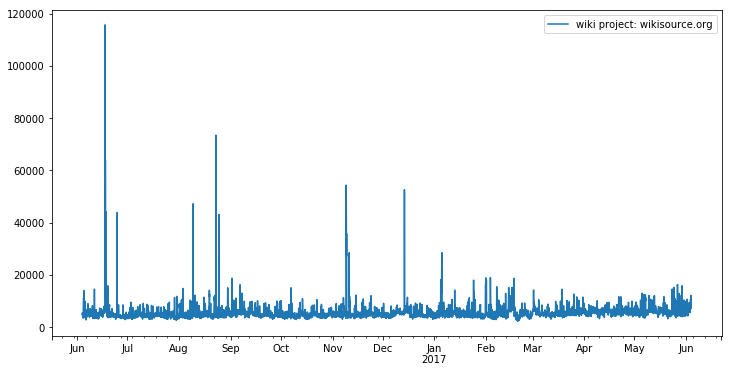

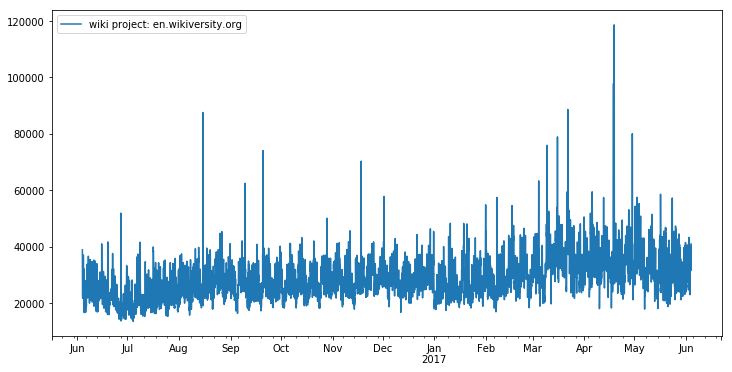

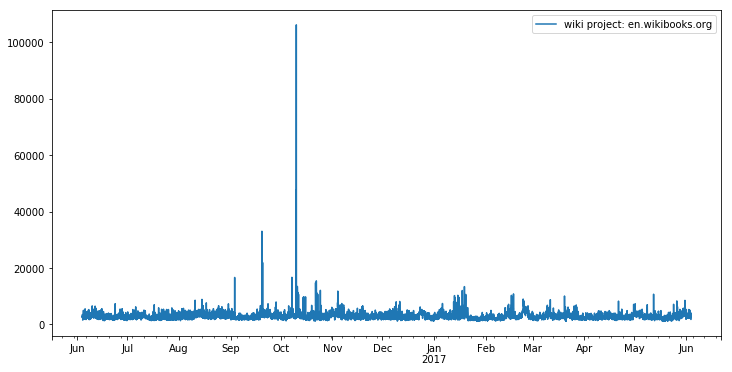

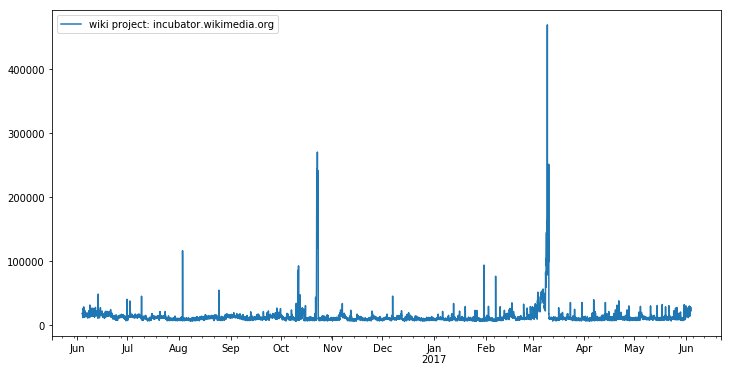

In [4]:
label_location = 'wp.txt'    
data_location = 'train_shortlist.json'
#data_location = "s3://{}/test/test.json".format(s3_data_path)
freq = 'H'

time_series_wiki, wp_list = get_ts(data_location,label_location,freq)

# plot some data
for k in [12,13,14,15]: # np.random.randint(low=0, high=num_ts-1, size=10):
    plt.figure(figsize=(12, 6))
    time_series_wiki[k][-year:].plot(label='wiki project: ' + wp_list[k])
    plt.legend()
    plt.show()

### Now we pick one of the time series to start the analysis. 
- Time domain: autocorrelation, rolling average, time series decomposition (seasonality, trendy, residual)
- Frequency domain (domaniant frequncy --> how the TS repeats itself and others)

In [5]:
pick_one = 15

### Time domain analysis

In [6]:
label_location = 'wp.txt'    
data_location = 'train_shortlist.json'
    
def time_domain_analysis(ts, label, window_size):
    import time
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # straight up plot
    plt.figure(figsize=(12, 6))
    x.plot(label='wiki project: ' + label)
    plt.title('time series plot')
    plt.legend()
    plt.show()
    
    # autocorrelation
    plt.figure(figsize=(15,5))
    pd.plotting.autocorrelation_plot(ts);
    plt.title('autocorrelation')
    
    # rolling average
    plt.figure(figsize=(12, 6))
    ts.rolling(window=window_size, center=False).mean().plot()
    plt.title('Rolling average')
    
    # rolling autocorrelation
    plt.figure(figsize=(12, 6))
    ts.rolling(window=window_size).corr(other=ts).plot()
    plt.title('Rolling autocorr')

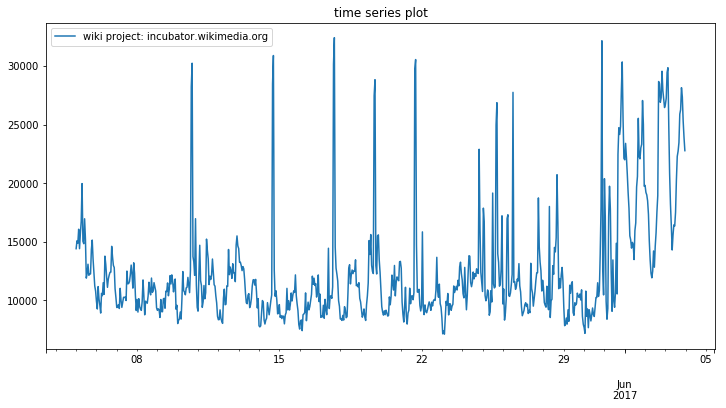

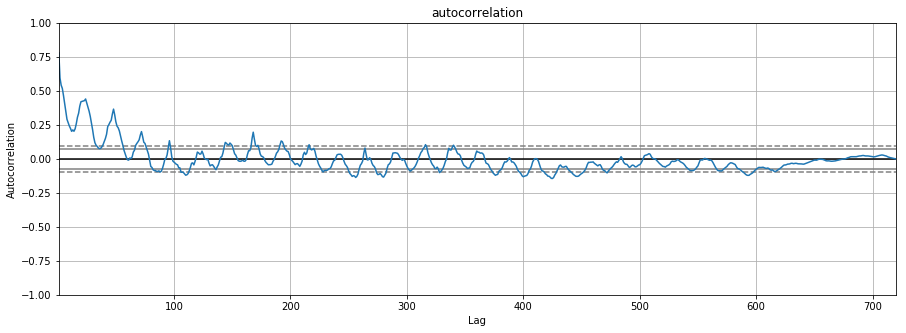

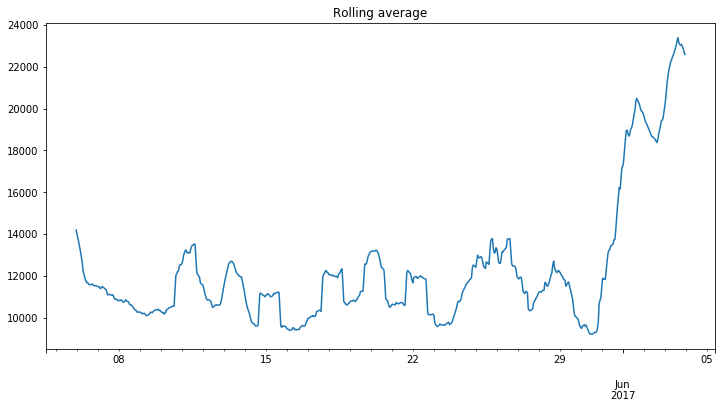

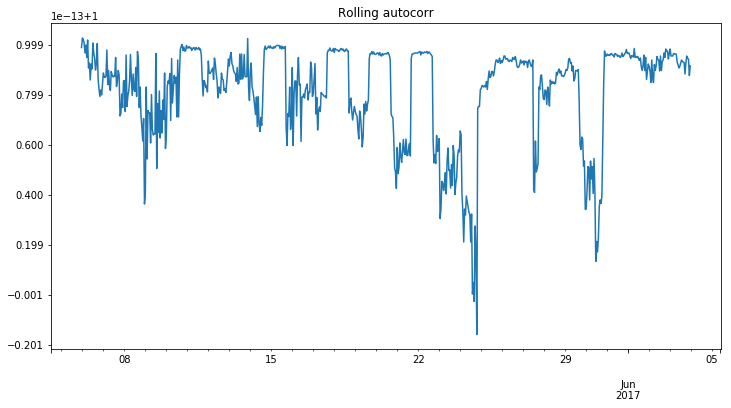

In [7]:
x = time_series_wiki[pick_one][-month:]
label = wp_list[pick_one]
time_domain_analysis(x, label, day)

### Time series decomposition: seasonality, trend, residual

In [8]:
# time series decomposition: a mutiplicative approach, better suits the current data
def ts_decomposition(ts, window):
    import pandas as pd
    from statsmodels.tsa.seasonal import seasonal_decompose
    result = seasonal_decompose(ts, model='multiplicative', freq=window)
    plt.figure()
    result.plot()
    plt.show()

Let's look at the Trend/Seasonal/Residual components of the data, use window = day

<Figure size 432x288 with 0 Axes>

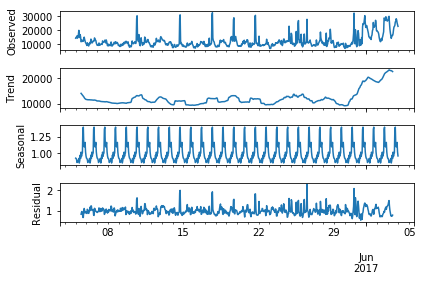

In [9]:
ts_decomposition(time_series_wiki[pick_one][-month:],day)

### Frequency domain analysis

In [10]:
# discrete Fourier transform with FFT
def discrete_ft(ts,window):
    # important variables are written explicitly
    y = x.values # signal

    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range

    # we only keep the positive frequency up to the Nyquist = 2*Fs
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(x)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('network traffic')
    ax[1].plot(cycle,abs(Y),'r') # plotting the spectrum
    ax[1].set_xlabel('cycles per '+str(window)+' hours')
    ax[1].set_ylabel('network frequency spectrum')

Let's look at the domaniant frequency of the input time series. Here I converted the frequncy into cycles: cyc = freq * window. For example, in window = 24, we can see how the pattern repeats itself per (*) day.

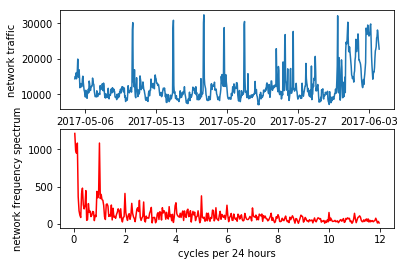

In [11]:
discrete_ft(time_series_wiki[pick_one][-year:],day)